<a href="https://colab.research.google.com/github/Urias-T/HDSC_Summer_2022/blob/main/Practical_Time_Series_Analysis_%26_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triumph's Submission For Hamoye Internship Stage E Quiz

## Stage E: Practical Time Series Analysis & Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.plot import plot_yearly, plot_weekly
from statsmodels.tsa.stattools import adfuller

**Define a function that calculates the Mape using the definition of MAPE from the course Module and pass your dataset into it.**

In [2]:
def mean_absolute_percentage_error(y, yhat):
  return round((np.mean(np.abs((y - yhat) / y) * 100)), 2)

In [ ]:
from google.colab import files

files.upload()

In [4]:
df_ori = pd.read_csv("/content/Time_series_analysis_and_forecast_DATASET.csv")
df_ori.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


# Data Visualization and Preparation

In [5]:
df1 = df_ori.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [6]:
df1["FullDate"] = pd.to_datetime(df1["FullDate"])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


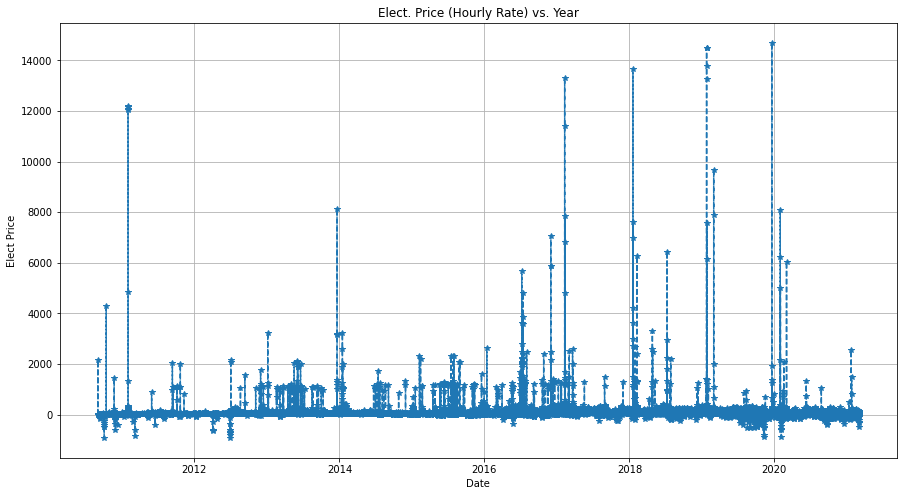

In [7]:
plt.figure(figsize = [15, 8])

plt.plot(df1["FullDate"], df1["ElecPrice"], "--", marker = "*")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Elect Price")
plt.title("Elect. Price (Hourly Rate) vs. Year");

In [8]:
df1_daily = df1.resample("D", on = "FullDate").sum().reset_index()
df1_daily.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


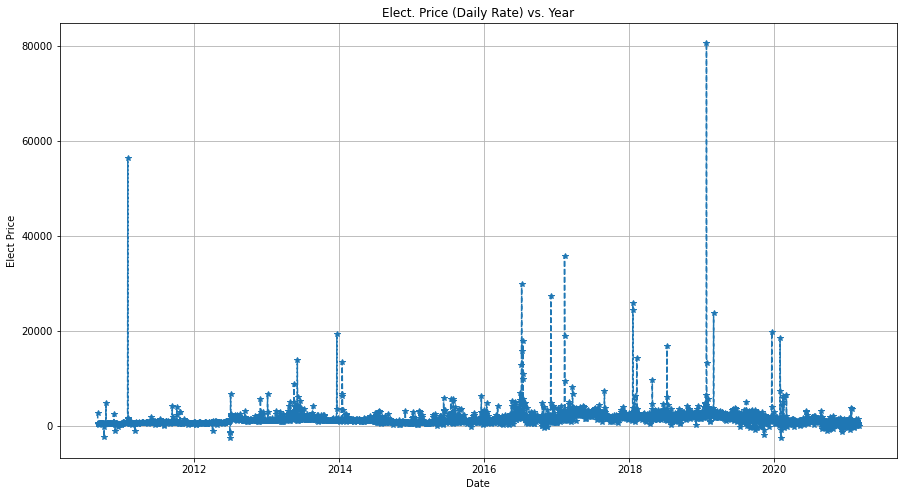

In [9]:
plt.figure(figsize = [15, 8])

plt.plot(df1_daily["FullDate"], df1_daily["ElecPrice"], "--", marker = "*")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Elect Price")
plt.title("Elect. Price (Daily Rate) vs. Year");

In [10]:
df1_daily.rename(columns = {"FullDate" : "ds", "ElecPrice" : "y"}, inplace = True)
df1_daily.columns

Index(['ds', 'Tmax', 'SysLoad', 'GasPrice', 'y'], dtype='object')

**Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?**

In [11]:
SysLoad_adf_result = adfuller(df1_daily["SysLoad"])

print("SysLoad p-value: {}".format(SysLoad_adf_result[1].round(6)))

SysLoad p-value: 0.004254


In [12]:
GasPrice_adf_resdults = adfuller(df1_daily["GasPrice"])

print("GasPice p-value: {}", format(GasPrice_adf_resdults[1].round(6)))

GasPice p-value: {} 0.045027


**Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?**

In [13]:
ElecPrice_adf_results = adfuller(df1_daily["y"])

for k, v in ElecPrice_adf_results[4].items():
  v = v.round(4)
  print(f"{k} : {v}")

1% : -3.4321
5% : -2.8623
10% : -2.5672


In [14]:
cutoff = 2757

df1_daily_train = df1_daily.iloc[0 : cutoff, ]
df1_daily_test = df1_daily.iloc[cutoff : , ]

print(df1_daily_train.shape)
print(df1_daily_test.shape)

(2757, 5)
(1077, 5)


In [15]:
df1_daily_train.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


# Univariate Model

In [16]:
uni_traindf = df1_daily_train[["ds", "y"]].copy()
uni_traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2757 non-null   datetime64[ns]
 1   y       2757 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.2 KB


In [17]:
uni_testdf = df1_daily_test[["ds", "y"]].copy()
uni_testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 2757 to 3833
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1077 non-null   datetime64[ns]
 1   y       1077 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.0 KB


In [18]:
uni_model = Prophet()

uni_model.fit(uni_traindf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/iy7_jt4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/mt5rodyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10638', 'data', 'file=/tmp/tmpvf6poitn/iy7_jt4d.json', 'init=/tmp/tmpvf6poitn/mt5rodyu.json', 'output', 'file=/tmp/tmp1_0qtyfn/prophet_model-20221004125047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
uni_predict = uni_testdf[["ds"]].copy()
uni_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 2757 to 3833
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1077 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.5 KB


In [20]:
uni_predict.head()

,ds
2757,2018-03-20
2758,2018-03-21
2759,2018-03-22
2760,2018-03-23
2761,2018-03-24


In [21]:
uni_forecast = uni_model.predict(uni_predict)
uni_forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "trend_lower", "trend_upper"]]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,2521.998098,92.220824,4905.577572,2676.996143,2676.996143,2676.996143
1,2018-03-21,2675.181324,281.334701,5148.766281,2677.763256,2677.763256,2677.763256
2,2018-03-22,2774.036399,451.458237,5068.717184,2678.530368,2678.530368,2678.530368
3,2018-03-23,2566.035844,128.377110,4780.274334,2679.297480,2679.297480,2679.297480
4,2018-03-24,2241.126584,-90.687226,4554.588023,2680.064592,2680.064592,2680.064592
...,...,...,...,...,...,...,...
1072,2021-02-24,3410.743291,504.224164,6077.704194,3499.340422,1922.229986,5022.822753
1073,2021-02-25,3477.583734,679.109537,6431.995192,3500.107534,1919.164432,5024.940549
1074,2021-02-26,3244.380463,181.343280,6262.292278,3500.874646,1916.098879,5027.058345
1075,2021-02-27,2901.031053,30.921354,5804.437091,3501.641758,1913.033325,5029.203602


In [22]:
uni_forecastdf = uni_forecast[["ds", "yhat"]]
uni_forecastdf.head()

,ds,yhat
0,2018-03-20,2521.998098
1,2018-03-21,2675.181324
2,2018-03-22,2774.036399
3,2018-03-23,2566.035844
4,2018-03-24,2241.126584


In [23]:
uni_testdf.head()

,ds,y
2757,2018-03-20,1833.00
2758,2018-03-21,1730.49
2759,2018-03-22,2260.55
2760,2018-03-23,2138.76
2761,2018-03-24,1721.70


In [24]:
uni_final = pd.merge(uni_testdf, uni_forecastdf, on = "ds")
uni_final.head()

,ds,y,yhat
0,2018-03-20,1833.00,2521.998098
1,2018-03-21,1730.49,2675.181324
2,2018-03-22,2260.55,2774.036399
3,2018-03-23,2138.76,2566.035844
4,2018-03-24,1721.70,2241.126584


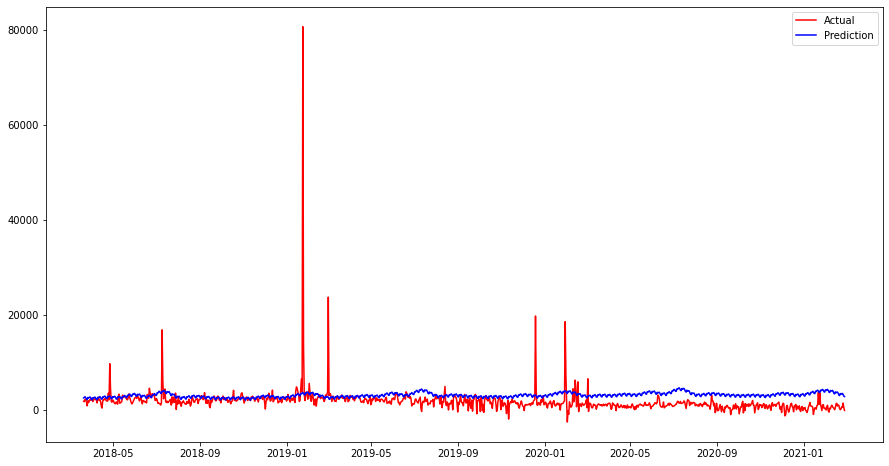

In [25]:
plt.figure(figsize = [15, 8])

plt.plot(uni_final["ds"], uni_final["y"], label = "Actual", color = "red")
plt.plot(uni_final["ds"], uni_final["yhat"], label = "Prediction", color = "blue")
plt.legend();

**Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?**

In [26]:
uni_MAPE = mean_absolute_percentage_error(uni_final["y"], uni_final["yhat"])
uni_MAPE

539.22

**What is the RMSE in 2 decimal places?**

In [27]:
uni_rms = sqrt(mean_squared_error(uni_final["y"], uni_final["yhat"]))
uni_rms = round(uni_rms, 2)
print(uni_rms)

3196.64


**If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?**

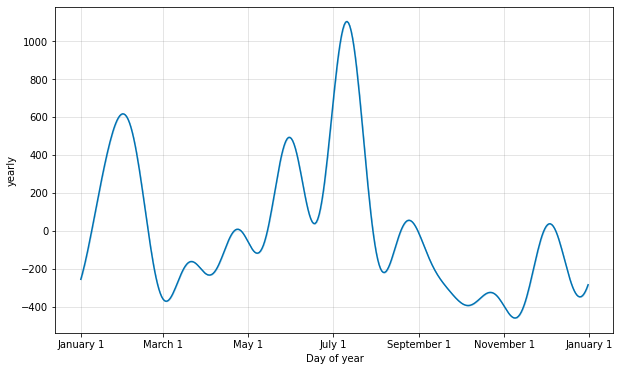

In [28]:
plot_yearly(uni_model)

# Multivariate Models

In [29]:
multi_model = Prophet()
multi_model.add_regressor("SysLoad")
multi_model.add_regressor("Tmax")
multi_model.add_regressor("GasPrice")
multi_model.fit(df1_daily_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/osybersl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/tyf_zhou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94108', 'data', 'file=/tmp/tmpvf6poitn/osybersl.json', 'init=/tmp/tmpvf6poitn/tyf_zhou.json', 'output', 'file=/tmp/tmpwhniyde8/prophet_model-20221004125053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
multi_predict = df1_daily_test[['ds', "SysLoad", "Tmax","GasPrice"]].copy()
multi_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 2757 to 3833
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        1077 non-null   datetime64[ns]
 1   SysLoad   1077 non-null   float64       
 2   Tmax      1077 non-null   float64       
 3   GasPrice  1077 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 33.8 KB


In [31]:
multi_predict.head()

,ds,SysLoad,Tmax,GasPrice
2757,2018-03-20,7696.91130,540.0,201.5880
2758,2018-03-21,4658.05865,571.2,203.2560
2759,2018-03-22,19161.78525,722.4,203.2560
2760,2018-03-23,18090.43435,811.2,198.6456
2761,2018-03-24,3763.53865,832.8,180.2160


In [32]:
multi_forecast = multi_model.predict(multi_predict)
multi_forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "trend_lower", "trend_upper"]]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,1988.494818,-178.709926,4301.570570,1867.223392,1867.223392,1867.223392
1,2018-03-21,1980.063539,-314.540428,4329.627296,1867.913438,1867.913438,1867.913438
2,2018-03-22,2899.369177,582.104886,5174.934861,1868.603483,1868.603483,1868.603483
3,2018-03-23,2583.628888,227.124787,4812.079248,1869.293529,1869.293529,1869.293529
4,2018-03-24,1437.347502,-692.318947,3570.941381,1869.983574,1869.983574,1869.983574
...,...,...,...,...,...,...,...
1072,2021-02-24,961.208123,-1242.195436,3315.356213,2606.952122,1857.771112,3428.289307
1073,2021-02-25,1320.421177,-1020.107104,3811.195220,2607.642167,1857.908448,3430.256865
1074,2021-02-26,1383.914142,-852.946128,3747.651485,2608.332213,1858.068485,3432.224424
1075,2021-02-27,1038.834888,-1390.226094,3236.267573,2609.022258,1858.273417,3434.191982


In [33]:
multi_forecastdf = multi_forecast[["ds", "yhat"]]
multi_forecastdf.head()

,ds,yhat
0,2018-03-20,1988.494818
1,2018-03-21,1980.063539
2,2018-03-22,2899.369177
3,2018-03-23,2583.628888
4,2018-03-24,1437.347502


In [34]:
df1_daily_testdf = df1_daily_test[["ds", "y"]]
df1_daily_testdf.head()

,ds,y
2757,2018-03-20,1833.00
2758,2018-03-21,1730.49
2759,2018-03-22,2260.55
2760,2018-03-23,2138.76
2761,2018-03-24,1721.70


In [35]:
multi_final = pd.merge(multi_forecastdf, df1_daily_testdf, on = "ds")
multi_final.head()

,ds,yhat,y
0,2018-03-20,1988.494818,1833.00
1,2018-03-21,1980.063539,1730.49
2,2018-03-22,2899.369177,2260.55
3,2018-03-23,2583.628888,2138.76
4,2018-03-24,1437.347502,1721.70


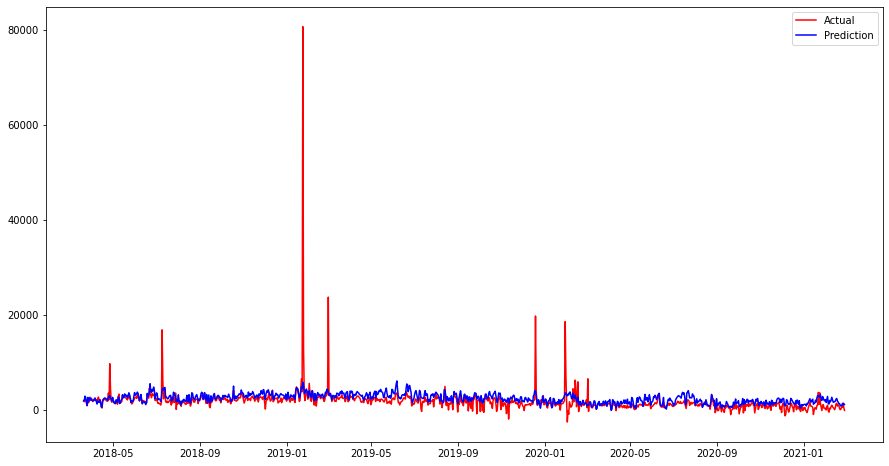

In [36]:
plt.figure(figsize = [15, 8])

plt.plot(multi_final["ds"], multi_final["y"], label = "Actual", color = "red")
plt.plot(multi_final["ds"], multi_final["yhat"], label = "Prediction", color = "blue")
plt.legend();

**Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?**

In [37]:
multi_MAPE = mean_absolute_percentage_error(multi_final["y"], multi_final["yhat"])
multi_MAPE

232.43

**What is the RMSE in 2 decimal places?**

In [38]:
multi_rms = sqrt(mean_squared_error(multi_final["y"], multi_final["yhat"]))
multi_rms = round(multi_rms, 2)
print(multi_rms)

2708.17


**If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?**

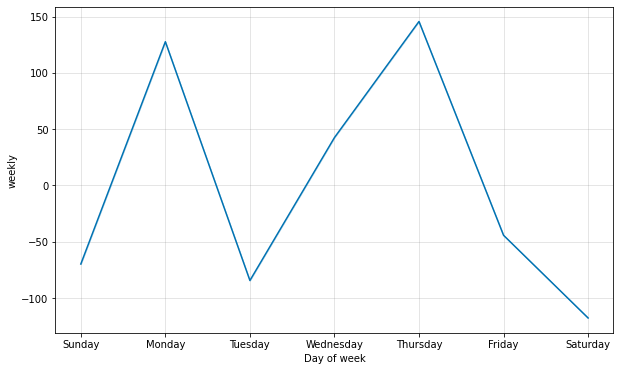

In [39]:
plot_weekly(multi_model)

**Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),**

In [40]:
multi_model2 = Prophet()
multi_model2.add_regressor("SysLoad")
multi_model2.add_regressor("GasPrice")
multi_model2.fit(df1_daily_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/cfdnhmcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6poitn/1qsky68t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97728', 'data', 'file=/tmp/tmpvf6poitn/cfdnhmcz.json', 'init=/tmp/tmpvf6poitn/1qsky68t.json', 'output', 'file=/tmp/tmp2_a9jp_v/prophet_model-20221004125057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [41]:
multi_predict2 = df1_daily_test[['ds', "SysLoad","GasPrice"]].copy()
multi_predict2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 2757 to 3833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        1077 non-null   datetime64[ns]
 1   SysLoad   1077 non-null   float64       
 2   GasPrice  1077 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.4 KB


In [42]:
multi_predict2.head()

,ds,SysLoad,GasPrice
2757,2018-03-20,7696.91130,201.5880
2758,2018-03-21,4658.05865,203.2560
2759,2018-03-22,19161.78525,203.2560
2760,2018-03-23,18090.43435,198.6456
2761,2018-03-24,3763.53865,180.2160


In [43]:
multi_forecast2 = multi_model2.predict(multi_predict2)
multi_forecast2[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "trend_lower", "trend_upper"]]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,1988.154678,-279.209202,4098.239486,1867.830813,1867.830813,1867.830813
1,2018-03-21,1979.613884,-145.979768,4241.937420,1868.521551,1868.521551,1868.521551
2,2018-03-22,2899.301882,854.074324,5113.196673,1869.212289,1869.212289,1869.212289
3,2018-03-23,2584.013509,525.624302,4972.562733,1869.903028,1869.903028,1869.903028
4,2018-03-24,1436.700243,-845.749955,3602.192668,1870.593766,1870.593766,1870.593766
...,...,...,...,...,...,...,...
1072,2021-02-24,959.967485,-1660.271642,3208.302289,2608.302297,1885.605255,3383.307011
1073,2021-02-25,1319.116986,-981.977752,3626.538845,2608.993035,1885.540217,3385.227444
1074,2021-02-26,1383.548481,-1045.266131,3705.178377,2609.683774,1885.490695,3386.378762
1075,2021-02-27,1038.155719,-1217.906525,3543.237681,2610.374512,1885.441173,3387.530080


In [44]:
multi_forecast2df = multi_forecast2[["ds", "yhat"]]
multi_forecast2df.head()

,ds,yhat
0,2018-03-20,1988.154678
1,2018-03-21,1979.613884
2,2018-03-22,2899.301882
3,2018-03-23,2584.013509
4,2018-03-24,1436.700243


In [45]:
multi_final2 = pd.merge(multi_forecast2df, df1_daily_testdf, on = "ds")
multi_final2.head()

,ds,yhat,y
0,2018-03-20,1988.154678,1833.00
1,2018-03-21,1979.613884,1730.49
2,2018-03-22,2899.301882,2260.55
3,2018-03-23,2584.013509,2138.76
4,2018-03-24,1436.700243,1721.70


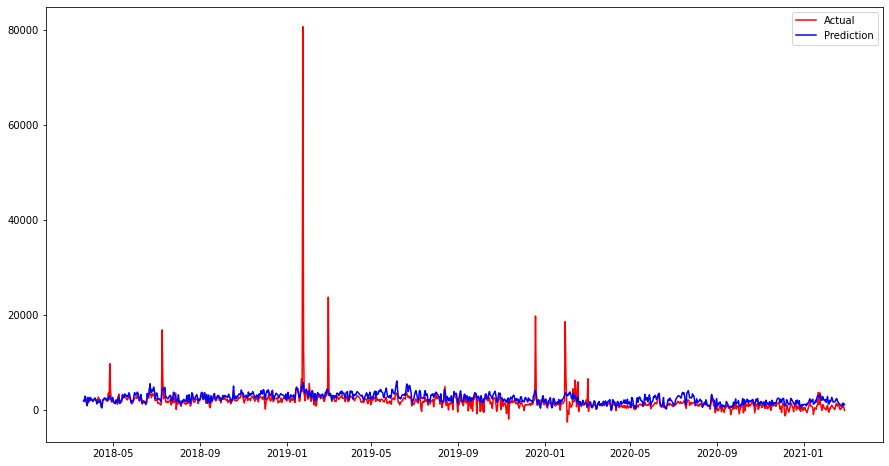

In [46]:
plt.figure(figsize = [15, 8])

plt.plot(multi_final2["ds"], multi_final2["y"], label = "Actual", color = "red")
plt.plot(multi_final2["ds"], multi_final2["yhat"], label = "Prediction", color = "blue")
plt.legend();

**What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?**

In [47]:
multi2_MAPE = mean_absolute_percentage_error(multi_final2["y"], multi_final2["yhat"])
multi2_MAPE

232.38